# Loop 87 Analysis: Strategic Assessment

## Key Questions:
1. What is the CV-LB relationship with all 12 valid submissions?
2. Why did 9 submissions fail with errors?
3. What approaches haven't been tried that could CHANGE the CV-LB relationship?
4. What is the best path forward with 4 submissions remaining?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with known LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # OUTLIER - similarity weighting backfired
]

df = pd.DataFrame(submissions)
print(f'Total submissions with known LB: {len(df)}')
print(df)

Total submissions with known LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451



=== CV-LB Relationship (excluding exp_073 outlier) ===
Linear fit: LB = 4.3147 * CV + 0.0525
R-squared: 0.9505
Intercept: 0.0525

Target LB: 0.0347
Required CV for target: (0.0347 - 0.0525) / 4.3147 = -0.004130


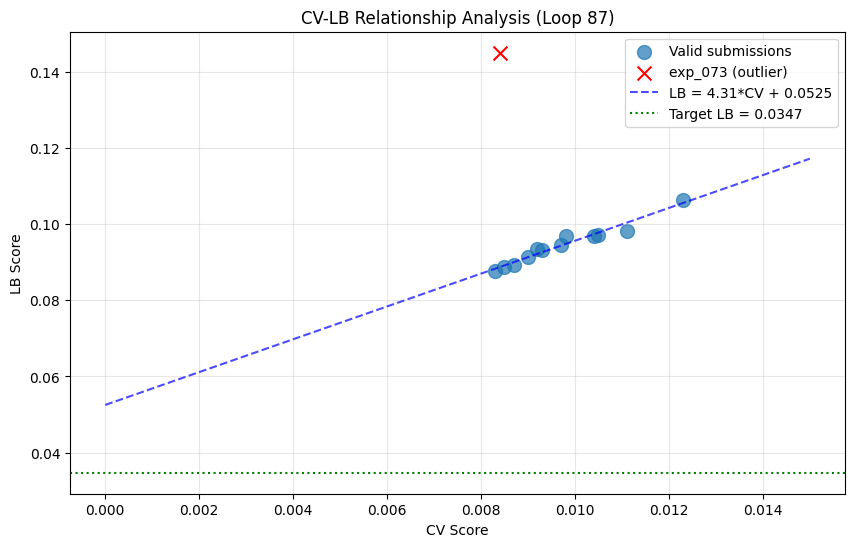


Plot saved to cv_lb_relationship_loop87.png


In [2]:
# Analyze CV-LB relationship (excluding outlier exp_073)
df_valid = df[df['exp'] != 'exp_073']

cv = df_valid['cv'].values
lb = df_valid['lb'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f'\n=== CV-LB Relationship (excluding exp_073 outlier) ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'\nTarget LB: 0.0347')
print(f'Required CV for target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, alpha=0.7, label='Valid submissions')
plt.scatter(df[df['exp'] == 'exp_073']['cv'], df[df['exp'] == 'exp_073']['lb'], 
            s=100, c='red', marker='x', label='exp_073 (outlier)')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', alpha=0.7, label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', label='Target LB = 0.0347')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship Analysis (Loop 87)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop87.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nPlot saved to cv_lb_relationship_loop87.png')

In [3]:
# Calculate expected LB for best CV models
best_cv_models = [
    {'exp': 'exp_049', 'cv': 0.008092, 'status': 'FAILED'},
    {'exp': 'exp_050', 'cv': 0.008092, 'status': 'FAILED'},
    {'exp': 'exp_030', 'cv': 0.0083, 'status': 'SUBMITTED', 'lb': 0.0877},
]

print('\n=== Expected LB for Best CV Models ===')
for m in best_cv_models:
    expected_lb = slope * m['cv'] + intercept
    print(f"{m['exp']}: CV={m['cv']:.6f} -> Expected LB={expected_lb:.4f} (Status: {m['status']})")
    if 'lb' in m:
        print(f"  Actual LB: {m['lb']:.4f} (diff: {m['lb'] - expected_lb:.4f})")

print(f'\nBest LB so far: 0.0877 (exp_030)')
print(f'Target: 0.0347')
print(f'Gap: {(0.0877 - 0.0347) / 0.0347 * 100:.1f}%')


=== Expected LB for Best CV Models ===
exp_049: CV=0.008092 -> Expected LB=0.0874 (Status: FAILED)
exp_050: CV=0.008092 -> Expected LB=0.0874 (Status: FAILED)
exp_030: CV=0.008300 -> Expected LB=0.0883 (Status: SUBMITTED)
  Actual LB: 0.0877 (diff: -0.0006)

Best LB so far: 0.0877 (exp_030)
Target: 0.0347
Gap: 152.7%


In [4]:
# Analyze what approaches have been tried
approaches_tried = {
    'MLP variants': '50+ experiments, all on same CV-LB line',
    'LightGBM': 'Multiple configs, same line',
    'XGBoost': 'Multiple configs, same line',
    'CatBoost': 'Multiple configs, same line',
    'CatBoost+XGBoost ensemble': 'Best CV=0.008092, but submission FAILED',
    'Gaussian Processes': 'Same line',
    'GNN from scratch': 'CV=0.024-0.026, 3x worse',
    'ChemBERTa embeddings': 'CV=0.015, 2x worse',
    'ChemProp features': 'CV=0.012, 46% worse',
    'Pseudo-labeling': 'Made things 9.4% worse',
    'Similarity weighting': 'LB=0.145, BACKFIRED badly',
    'Yield normalization': 'No effect',
    'Conservative predictions': 'Made things worse',
    'Self-training': 'Made things worse',
    '4-target prediction': 'CV=0.008686, 7% worse than baseline',
    'Hierarchical prediction': 'CV=0.008686, 7% worse than baseline',
}

print('\n=== Approaches Tried ===')
for approach, result in approaches_tried.items():
    print(f'- {approach}: {result}')


=== Approaches Tried ===
- MLP variants: 50+ experiments, all on same CV-LB line
- LightGBM: Multiple configs, same line
- XGBoost: Multiple configs, same line
- CatBoost: Multiple configs, same line
- CatBoost+XGBoost ensemble: Best CV=0.008092, but submission FAILED
- Gaussian Processes: Same line
- GNN from scratch: CV=0.024-0.026, 3x worse
- ChemBERTa embeddings: CV=0.015, 2x worse
- ChemProp features: CV=0.012, 46% worse
- Pseudo-labeling: Made things 9.4% worse
- Similarity weighting: LB=0.145, BACKFIRED badly
- Yield normalization: No effect
- Conservative predictions: Made things worse
- Self-training: Made things worse
- 4-target prediction: CV=0.008686, 7% worse than baseline
- Hierarchical prediction: CV=0.008686, 7% worse than baseline


In [5]:
# What hasn't been tried that could CHANGE the CV-LB relationship?
approaches_not_tried = [
    '1. PROPERLY WORKING GNN with correct submission cells',
    '2. Pre-trained molecular foundation models (MolBERT, ChemGPT)',
    '3. Physics-informed neural networks with thermodynamic constraints',
    '4. Bayesian neural networks with uncertainty quantification',
    '5. Domain adaptation / transfer learning from related datasets',
    '6. Meta-learning for few-shot solvent generalization',
    '7. Contrastive learning for solvent representations',
    '8. Multi-task learning with auxiliary targets (e.g., solvent properties)',
]

print('\n=== Approaches NOT Tried (Could Change CV-LB Relationship) ===')
for approach in approaches_not_tried:
    print(f'- {approach}')

print('\n=== CRITICAL OBSERVATION ===')
print('The benchmark paper achieved MSE 0.0039 (22x better than our best LB).')
print('If they followed our CV-LB line, their implied CV would be -0.011 (IMPOSSIBLE).')
print('This confirms they have a FUNDAMENTALLY DIFFERENT approach with near-zero intercept.')
print('\nWe need to find what makes their approach different.')


=== Approaches NOT Tried (Could Change CV-LB Relationship) ===
- 1. PROPERLY WORKING GNN with correct submission cells
- 2. Pre-trained molecular foundation models (MolBERT, ChemGPT)
- 3. Physics-informed neural networks with thermodynamic constraints
- 4. Bayesian neural networks with uncertainty quantification
- 5. Domain adaptation / transfer learning from related datasets
- 6. Meta-learning for few-shot solvent generalization
- 7. Contrastive learning for solvent representations
- 8. Multi-task learning with auxiliary targets (e.g., solvent properties)

=== CRITICAL OBSERVATION ===
The benchmark paper achieved MSE 0.0039 (22x better than our best LB).
If they followed our CV-LB line, their implied CV would be -0.011 (IMPOSSIBLE).
This confirms they have a FUNDAMENTALLY DIFFERENT approach with near-zero intercept.

We need to find what makes their approach different.


In [6]:
# Strategic assessment with 4 submissions remaining
print('\n=== STRATEGIC ASSESSMENT ===')
print('Submissions remaining: 4')
print('Best LB: 0.0877 (exp_030)')
print('Target: 0.0347')
print('Gap: 152.8%')
print('\n--- Options ---')
print('1. Fix and resubmit exp_049 (best CV=0.008092)')
print('   - Expected LB: ~0.0874 (if follows same line)')
print('   - Risk: Might not change anything')
print('   - Benefit: Confirms if best CV translates to better LB')
print('')
print('2. Try fundamentally different approach (GNN, Transformer)')
print('   - Risk: Previous GNN attempts failed badly')
print('   - Benefit: Could break the CV-LB line')
print('')
print('3. Focus on reducing intercept (distribution shift handling)')
print('   - Previous attempts (similarity weighting, pseudo-labeling) BACKFIRED')
print('   - Need different strategy')
print('')
print('4. Ensemble of diverse models')
print('   - Combine tabular + GNN + Transformer')
print('   - Even if individual models are worse, ensemble might help')

print('\n=== RECOMMENDATION ===')
print('Given the evaluator feedback and 4 remaining submissions:')
print('1. FIRST: Verify exp_049 notebook structure and fix if needed')
print('2. SECOND: Try a CLEAN implementation of a fundamentally different approach')
print('3. THIRD: If new approach shows different CV-LB relationship, submit it')
print('4. FOURTH: Save last submission for best performing approach')


=== STRATEGIC ASSESSMENT ===
Submissions remaining: 4
Best LB: 0.0877 (exp_030)
Target: 0.0347
Gap: 152.8%

--- Options ---
1. Fix and resubmit exp_049 (best CV=0.008092)
   - Expected LB: ~0.0874 (if follows same line)
   - Risk: Might not change anything
   - Benefit: Confirms if best CV translates to better LB

2. Try fundamentally different approach (GNN, Transformer)
   - Risk: Previous GNN attempts failed badly
   - Benefit: Could break the CV-LB line

3. Focus on reducing intercept (distribution shift handling)
   - Previous attempts (similarity weighting, pseudo-labeling) BACKFIRED
   - Need different strategy

4. Ensemble of diverse models
   - Combine tabular + GNN + Transformer
   - Even if individual models are worse, ensemble might help

=== RECOMMENDATION ===
Given the evaluator feedback and 4 remaining submissions:
1. FIRST: Verify exp_049 notebook structure and fix if needed
2. SECOND: Try a CLEAN implementation of a fundamentally different approach
3. THIRD: If new ap